# **Set up**

In [1]:
!pip install summarytools
!pip install vncorenlp

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.4 MB/s eta 0:00:00
  Created wheel for summarytools: filename=summarytools-0.2.3-py3-none-any.whl size=8572 sha256=03a23595fca769c8bfe58fa733cd776352ca3d49c8aed7931b5a48a92f21e54f
  Stored in directory: /root/.cache/pip/wheels/d5/8a/5d/008e2127a7f9dd64d066f16e5ea268fa52823dc929c982d6f1
Successfully built summarytools
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645932 sha256=8f5c726851e1413889958b07dafff906d554f8d102cf6bffea4409dd05251545
  Stored in directory: /root/.cache/pip/wheels/5d/d9/b3/41f6c6b1ab758561fd4aab55dc0480b9d7a131c6aaa573a3fa
Successfully built vncorenlp


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from vncorenlp import VnCoreNLP
from sklearn.decomposition import PCA

from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from summarytools import dfSummary
from collections import Counter

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

--2023-12-31 15:30:27--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M  --.-KB/s    in 0.1s    

2023-12-31 15:30:29 (222 MB/s) - ‘VnCoreNLP-1.1.1.jar’ saved [27412575/27412575]

--2023-12-31 15:30:29--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting respon

# **Training Set Preparation**

In [5]:
aspect_cols = ['GENERAL', 'SCREEN', 'CAMERA', 'FEATURES', 'BATTERY', 'PERFORMANCE', 'STORAGE', 'DESIGN', 'PRICE', 'SER&ACC']

In [6]:
df_train = pd.read_csv("/content/drive/MyDrive/HocMayThongKe/Project/Preprocessed Dataset/df_train.csv")
df_train

,comment,GENERAL,SCREEN,CAMERA,FEATURES,BATTERY,PERFORMANCE,STORAGE,DESIGN,PRICE,SER&ACC,OTHERS
0,Mới mua máy này Tại thegioididong thốt nốt cảm...,1,0,1,1,1,0,0,0,1,1,0
1,Pin kém còn lại miễn chê mua 8/3/2019 tình trạ...,1,0,0,0,-1,0,0,0,0,0,1
2,Sao lúc gọi điện thoại màn hình bị chấm nhỏ nh...,0,0,0,-1,0,0,0,0,0,0,0
3,"Mọi người cập nhật phần mềm lại , nó sẽ bớt tố...",0,0,0,-1,0,0,0,0,0,0,0
4,"Mới mua Sài được 1 tháng thấy pin rất trâu, Sà...",0,0,0,0,1,1,0,0,0,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7781,8g. Cái đi đánh là mạng giật giật ko chịu nổi....,0,0,0,-1,-1,-1,0,0,0,0,0
7782,Mua dk giảm 500k mà lỗi lòi ra hết treo màn hì...,0,0,0,-1,0,-1,0,0,1,0,0
7783,Máy Sài 3 tháng rồi rất OK.pin trâu khỏi nói S...,1,0,0,0,1,1,0,0,0,0,0
7784,"Rất tiếc hàng realme ko có ốp lưng ngoài , nên...",1,0,0,0,0,0,0,0,-1,-1,0


In [7]:
rdrsegmenter = VnCoreNLP("/content/vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')

In [8]:
def tokenize(row):
    processed_row = ""
    tokenized_sents = rdrsegmenter.tokenize(row)
    for lst_token_in_sent in tokenized_sents:
        processed_row += " ".join(lst_token_in_sent)

    return processed_row

In [9]:
def dataframe_tokenize(df):
    processed_rows = []
    for row in df['comment']:
        processed_rows.append(tokenize(row))

    return processed_rows

In [10]:
tfidf_vectorizer = TfidfVectorizer()

X_train_tok = dataframe_tokenize(df_train)

X_train_tok_enc = tfidf_vectorizer.fit_transform(X_train_tok)
X_train_tok_enc.toarray().shape

(7786, 8381)

In [11]:
y_train = df_train.iloc[:, 1:]
y_train.shape

(7786, 11)

In [12]:
min_values = np.min(X_train_tok_enc, axis=0)
max_values = np.max(X_train_tok_enc, axis=0)
diff = max_values.toarray() - min_values.toarray() # alternative way, max_values.A - min_values.A
diff

array([[0.47297229, 0.59704759, 0.37239204, ..., 0.25855725, 0.40960783,
        0.16766541]])

Text(0.5, 1.0, 'Min-Max Range Distribution Of All Feature Columns in Train Set')

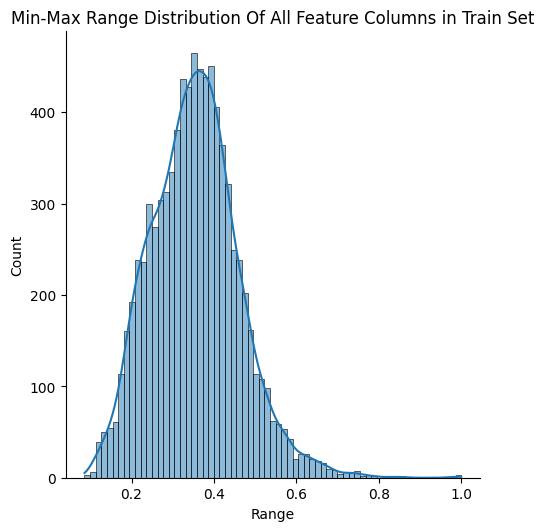

In [13]:
diff = diff.flatten()

sns.displot(diff, kde=True)
plt.ylabel('Count')
plt.xlabel('Range')
plt.title('Min-Max Range Distribution Of All Feature Columns in Train Set')

# **Testing Set Preparation**

In [14]:
df_test = pd.read_csv("/content/drive/MyDrive/HocMayThongKe/Project/Preprocessed Dataset/df_test.csv")
df_test

,comment,GENERAL,SCREEN,CAMERA,FEATURES,BATTERY,PERFORMANCE,STORAGE,DESIGN,PRICE,SER&ACC,OTHERS
0,"Điện thoải ổn. Facelock cực nhanh, vân tay ôk ...",1,1,0,1,0,1,0,0,0,0,0
1,"Mình mới mua vivo91c. Tải ứng dụng ,games nh...",0,0,0,-1,0,1,0,0,0,1,1
2,Xấu đẹp gì ko biết nhưng rất ưng TGdđ phục vụ ...,0,0,0,0,0,0,0,0,0,1,0
3,Màn hình hơi lác khi chơi game. Game nặng thì ...,0,0,0,0,0,-1,0,-1,0,0,1
4,"Nói chung máy đẹp với màn amoled, ổn trong tầm...",0,1,0,0,-1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2219,"Mẫu mã đẹp lung linh. Máy chạy cực nhanh, mượt...",0,0,0,1,0,1,0,1,0,0,1
2220,Có ai bị giống mình không máy thì sài bình thư...,0,0,0,0,0,-1,0,0,0,0,0
2221,Sản phẩm tốt 😊\nAi chơi game cứ mang 1 em về m...,1,0,0,0,0,1,0,0,0,0,0
2222,Vừa mới mua xong máy rất đẹp nhân viên rất nhi...,0,0,1,0,1,1,0,1,0,1,0


In [15]:
X_test_tok = dataframe_tokenize(df_test)
X_test_tok_enc = tfidf_vectorizer.transform(X_test_tok)
X_test_tok_enc.toarray().shape

(2224, 8381)

In [16]:
y_test = df_test.iloc[:, 1:]
y_test.shape

(2224, 11)

Text(0.5, 1.0, 'Min-Max Range Distribution Of All Feature Columns in Test Set')

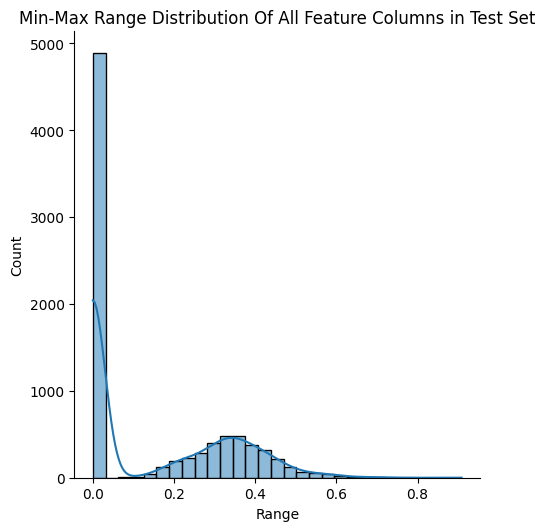

In [17]:
min_values = np.min(X_test_tok_enc, axis=0)
max_values = np.max(X_test_tok_enc, axis=0)
diff = max_values.toarray() - min_values.toarray() # alternative way, max_values.A - min_values.A

diff = diff.flatten()

sns.displot(diff, kde=True)
plt.ylabel('Count')
plt.xlabel('Range')
plt.title('Min-Max Range Distribution Of All Feature Columns in Test Set')

# **Dataset Statistic**

Text(0.5, 1.0, 'Statistics on the number of samples in training & testing set')

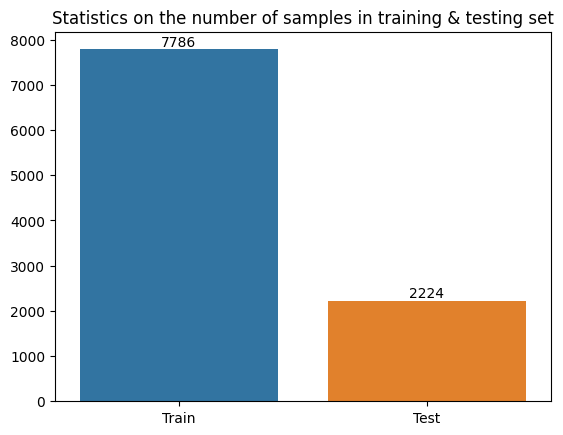

In [18]:
size = [df_train.shape[0], df_test.shape[0]]
ax = sns.barplot(x=['Train', 'Test'], y=size)

for i, v in enumerate(size):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom')

plt.title('Statistics on the number of samples in training & testing set')

In [19]:
# Training Data Frame Summary
dfSummary(df_train.iloc[:,1:])

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,GENERAL[int64],1. 12. 03. -1,"3,627 (46.6%)3,210 (41.2%)949 (12.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABlklEQVR4nO3bQWrbYBSF0aciQjORMAYvxovoYrsI7cYYa5CETNRBp20csLi/sM5ZwbP5sJHx7ZZlKUj40foA9qOrqteqeml9yIZ9Lsvy3vqIZ9Afj8dfwzAcWh+yVfM8X7uu+y24x/XDMBzO5/P7OI4frY/Zmtvt9nOapsPlcnmpKrE9qK+qGsfx43Q6vbU+ZqNeWx/wLDwgECM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiOmr/r7v63Wh2yR92Vd/TzP12maDuV/W/80z/O1qj5b3/EMbBDus0FYSWfKR4pPNp9cMbtfV1lP5ex6XWU9lWVd5Sk8xo+6xIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IjZ9bpqr6+7ld2vq6yncmwQbBBirKuI8YBAzNpfo76S+K9Vp3xmcXxltSmfWRz3rD3l2+XPJ3yPBwRixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxKw25TOL455Vp3xmcXzFBoEYUz5i/gBKvKNKS0O41wAAAABJRU5ErkJggg=="">",0(0.0%)
2,SCREEN[int64],1. 02. 13. -1,"6,893 (88.5%)514 (6.6%)379 (4.9%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABlElEQVR4nO3bQUrDUBiF0T9SRCcJpdDFdBEu1kVkN6U0AxUnceBcI3ncSnPOAsIbfDS8ktvN81yQ8HDrA7AdXVU9V9XjrQ/Cv/Y5z/P72ofsDofDS9/3+xYn4j5N03Tpuu51bXC7vu/3p9PpfRiGj1aH435cr9encRz35/P5sarWxVZVNQzDx/F4fGtyOu7Rc4uHuCAQIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI2ZX9f3N0q0Pwv/Uso3dNE2XcRz31eibJe7PNE2Xqvpc+xwbBJZoskHoTPlI+csvW5O62a7F66pWCxu2a9G6quXChu36y7rKbZVV/KlLjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjZhF6yrrK1pYvK5qtbBhu2wQiLGuIsYFgZglr1GvT5r4dcpnwkcrP075TPhoacmUz4SPJlwQiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsRHz45TPhI+Wfp3ymfDRig0CMaZ8xHwBSryjShsbZNcAAAAASUVORK5CYII="">",0(0.0%)
3,CAMERA[int64],1. 02. 13. -1,"5,928 (76.1%)1,231 (15.8%)627 (8.1%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABmElEQVR4nO3bQWrbYBSF0adiQjORMAYvxovoYrsI7cYYa5CETJRBJ6EzK8r9f9pzVvDAn21kfId1XQsSfrQ+gP/HUFXPVfXU+hB2976u62vrIz47nE6nX+M4Hlsfwr6WZbkNw/C7p+AO4zgeL5fL6zRNb62PYR/3+/3nPM/H6/X6VFX9xFZVNU3T2/l8fml9DLt6bn3A3zwgECM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiPmUPXn/0+tD2E/vb6eh2VZbvM8H6vD/z+x3bIst6p6b33HZzYI/67uNgiDKR8pqU+27t5l5EXWVT0ufcj79nVVr0sf8lLrKk+6+FGXHLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzHfvq7qdelDXmRd1ePShzwbBGKsq4jxgEDMlq9RX4ls8vCUzyyPrR6a8pnl8RVbpnxmeWziAYEYsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMQ9N+czy+IqHp3xmeWxlg0CMKR8xH0q8o0rA5ZlRAAAAAElFTkSuQmCC"">",0(0.0%)
4,FEATURES[int64],1. 02. -13. 1,"5,342 (68.6%)1,659 (21.3%)785 (10.1%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABnklEQVR4nO3bQW7aYBSF0ecKRc3EFkJiMSyii+0ivBuE8CCJMnEHnbYxkaP7g3POCp7EB8iI283zXJDwo/UBfB9dVT1X1VPrQ1j0Ps/za+sj1tgdDodffd/vWx/Cx6ZpunRd9/uRg9v1fb8/nU6vwzC8tT6Gf7terz/Hcdyfz+enqnrc2KqqhmF4Ox6PL62P4UPPrQ9YywMCMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmJ2VX//L9X6EP5vK6/PbpqmyziO+9rA/6W2bJqmS1W9t75jDRuEx/HwG4TOlI+Ue/lke/h3LcvuYl21heUQy5qvq7ayHGLZvayrPAl/A37UJUZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEZM83XVVpZDLLuLddUWlkMss0EgxrqKGA8IxHzF16ivQG6yespnhsetVk35zPD4jK+Y8pnhcRMPCMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIWTXlM8PjM1ZP+czwuJUNAjGmfMT8AUq8o0r0cr6oAAAAAElFTkSuQmCC"">",0(0.0%)
5,BATTERY[int64],1. 02. 13. -1,"4,531 (58.2%)2,027 (26.0%)1,228 (15.8%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABlUlEQVR4nO3bwWnjYBSF0afBhGQjYQwuxkVMsVOEujHGWiQhG2URAlkP+P7Kr3MqeJgPGwnfYV3XgoQ/rQ9gP4aqeqmqp9aH7MDHuq5vrY9o6XA6nf6O43hsfUjvlmW5DcPwb8/BHcZxPF4ul7dpmt5bH9Or+/3+PM/z8Xq9PlXVfmOrqpqm6f18Pr+2PqZzL60PaM0DAjFiI0ZsxIiNGLERIz

In [20]:
# Testing Data Frame Summary
dfSummary(df_test.iloc[:,1:])

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,GENERAL[int64],1. 12. 03. -1,"1,004 (45.1%)926 (41.6%)294 (13.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABlklEQVR4nO3bQWrqABSF4ZtHkHaSIIKLcRFd7FtEdiNiBq+lk7yBo0J1FE+C+b4VXOVHiXiaaZoKEv4sfQDb0VTVe1Xtlj5khb6nafpc+ohX0h4Oh4+u6/ZLH7I24zhemqb5K7j5tF3X7U+n02ff919LH7MW1+v1bRiG/fl83lWV2GbSVlX1ff91PB7/LX3MyrwvfcCr8YBAjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjZi26vb/raUPWRPvx3O04zhehmHYl/9v/TCO46Wqvpe+45XYINxngzCzxpSPFJ9sNz7FAqyrypIqZfPrKkuqHOuqG0/iAX7UJUZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEbM5tdVW37tadZVZUmVYoNwY4MQYF1FjAcEYp7xNeoriV/NPuUzi+OeWad8ZnE88owp32Z/QuExDwjEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiJl1ymcWxyOzT/nM4rjHBoEYUz5i/gNKvKNKeqLeDAAAAABJRU5ErkJggg=="">",0(0.0%)
2,SCREEN[int64],1. 02. 13. -1,"1,972 (88.7%)136 (6.1%)116 (5.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABk0lEQVR4nO3bQUrDUBiF0T9SRCcJpdDFdBEu1kVkN6U0AxUnceDcBvK4leacBYQ3+Gh4Jbeb57kg4eneB2A7uqp6rarnex+Ef+17nufPtQ/ZHQ6Ht77v9y1OxGOapunSdd372uB2fd/vT6fT5zAMX60Ox+O4Xq8v4zjuz+fzc1Wti62qahiGr+Px+NHkdDyi1xYPcUEgRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERsyu6vebpXsfhP+pZRu7aZou4zjuq9E3SzyeaZouVfW99jk2CCzRZIPQmfKRsvSXrUnZbNuidVWrdQ3bdnNd1XJdw7YtXVe5qbKaP3WJERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixEXNzXWV5RSuL1lWt1jVsmw0CMdZVxLggELPkNeoVShM3p3xmfLTy55TPjI+Wlkz5zPhowgWBGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzF/TvnM+Gjp5pTPjI9WbBCIMeUj5gfWeKNKQUoTegAAAABJRU5ErkJggg=="">",0(0.0%)
3,CAMERA[int64],1. 02. 13. -1,"1,707 (76.8%)346 (15.6%)171 (7.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABnElEQVR4nO3bQWoiYRSF0VeNhM6kChFcjIvoxfYiajci1iAJmVQGTaCnlnr/n+5zVvDAT6XEO6zrWpDwo/UB/D+GqnqtqpfWh/AUn+u6vrc+4tvucDj8Gsdx3/oQHm9ZlsswDL97CW43juP+dDq9T9P00foYHud6vf6c53l/Pp9fqqqP2Kqqpmn6OB6Pb62P4eFeWx/wNw8IxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IjZVf3571PrQ3isHl/T3bIsl3me99XZf5+437Isl6r6bH3HNxuEf1tXG4TBlI+UxCdbV+8u2nn6uqq3hQ/tPHVd1ePCh3YS6ypPuVSVH3UJEhsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixEfPUdVWPCx/aefq6qreFD+3YIBBjXUWMBwRitnyN+lpkk5unfKZ5bHXTlM80j3tsmfKZ5rGJBwRixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxNw05TPN4x43T/lM89jKBoEYUz5ivgBKvKNKOIK9wQAAAABJRU5ErkJggg=="">",0(0.0%)
4,FEATURES[int64],1. 02. -13. 1,"1,565 (70.4%)459 (20.6%)200 (9.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABmklEQVR4nO3bUWoiQRiF0epBwuSlGxFcjIvIYmcRvRsR62ES8tLzMAuI1YFbKTxnBT/4qbR4p23bCiT86n0Az2MqpbyWUl56H0KTz23b3nsf0epwOp3e5nk+9j6Ex9Vab9M0/RktuMM8z8fL5fK+LMtH72P42v1+/72u6/F6vb6UUsaKrZRSlmX5OJ/Pf3sfw8Neex+whwcEYsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMQcSvn/H6neh/CYkV+rQ631tq7rsQz6H6lnVGu9lVI+e9/RygZhTENuECZTPlJ+wifbkO9S2nVfV426FKJd13XVyEsh2v2EdZWn4CfhR11ixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxHRdV428FKJd93XVqEsh2tkgEGNdRYwHBGK+8zXq648mu6d8Jni02jXlM8Fjj+9M+UzwaOIBgRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxu6Z8JnjssXvKZ4JHKxsEYkz5iPkHSryjSi8JiAsAAAAASUVORK5CYII="">",0(0.0%)
5,BATTERY[int64],1. 02. 13. -1,"1,302 (58.5%)554 (24.9%)368 (16.5%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABjklEQVR4nO3bwWnDQBgF4acgTHyREAYX4yJSbIpQN8J4D7HxRTmkhMDsop2vgh8z2Ej4Dfu+RyJ81D5A/RiSnJOcah/Sife+78/aR9QyXi6Xr2maltqH9KCUch+G4bvX4MZpmpbb7fac5/lV+5gjezwen+u6Ltu2nZL0GVuSzPP8ul6vP7WP6cC59gE1+YAgjLEJY2zCGJswxiaMsQljbMIYmzDGJoyxC

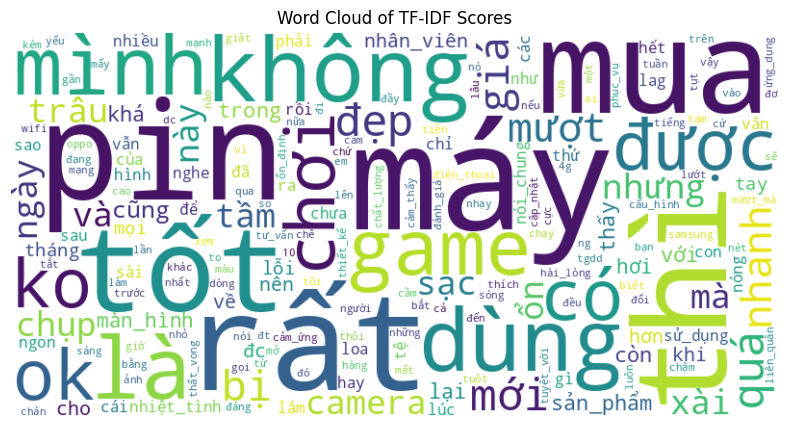

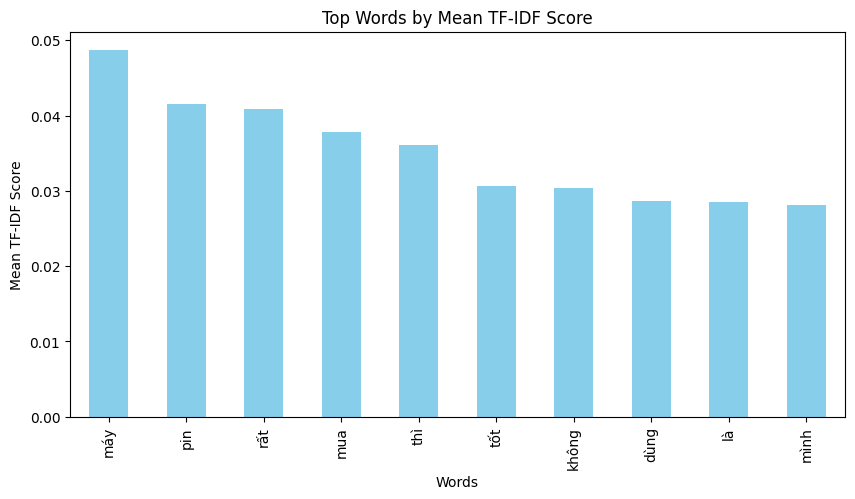

In [21]:
from wordcloud import WordCloud
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a DataFrame with TF-IDF scores
df_tfidf_train = pd.DataFrame(data=X_train_tok_enc.toarray(), columns=feature_names)

# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(df_tfidf_train.sum().to_dict())

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of TF-IDF Scores')
plt.show()

# Bar Chart
mean_tfidf = df_tfidf_train.mean().sort_values(ascending=False)
top_words = mean_tfidf.head(10)  # Adjust the number of top words as needed

plt.figure(figsize=(10, 5))
top_words.plot(kind='bar', color='skyblue')
plt.xlabel('Words')
plt.ylabel('Mean TF-IDF Score')
plt.title('Top Words by Mean TF-IDF Score')
plt.show()

In [32]:
def visualize_top_frequent_word(class_name):
  class_val = None
  if class_name == "Positive":
    class_val = 1
  elif class_name == "Nagative":
    class_val = -1
  else:
    class_val = 0

  # Number of aspect_cols
  num_aspect_cols = len(aspect_cols)

  # Calculate the number of rows needed based on two columns per row
  num_rows = (num_aspect_cols + 1) // 2

  # Create a subplot grid with two columns
  fig, axes = plt.subplots(num_rows, 2, figsize=(15, 4 * num_rows))

  # Loop through each aspect column
  for i, col in enumerate(aspect_cols):
      # Calculate row and column index for the subplot
      row_index = i // 2
      col_index = i % 2

      # Select rows where col == 1 and extract comments
      selected_rows = df_train[df_train[col] == class_val]['comment']

      # Split comments into words and count frequencies
      lst = [word for row in selected_rows for word in row.split(' ')]
      word_counts = Counter(lst)

      # Select top N words
      top_n = 10
      top_words = dict(word_counts.most_common(top_n))

      # Plot bar chart in the (row_index, col_index)-th subplot
      axes[row_index, col_index].bar(top_words.keys(), top_words.values())
      axes[row_index, col_index].set_title(f'Top {top_n} Most Frequent Words in {class_name} {col} Comments')
      axes[row_index, col_index].set_xlabel('Words')
      axes[row_index, col_index].set_ylabel('Frequency')

  # Remove empty subplots if the number of aspect_cols is odd
  if num_aspect_cols % 2 == 1:
      fig.delaxes(axes[-1, -1])

  # Automatically adjust layout
  plt.tight_layout()
  plt.show()

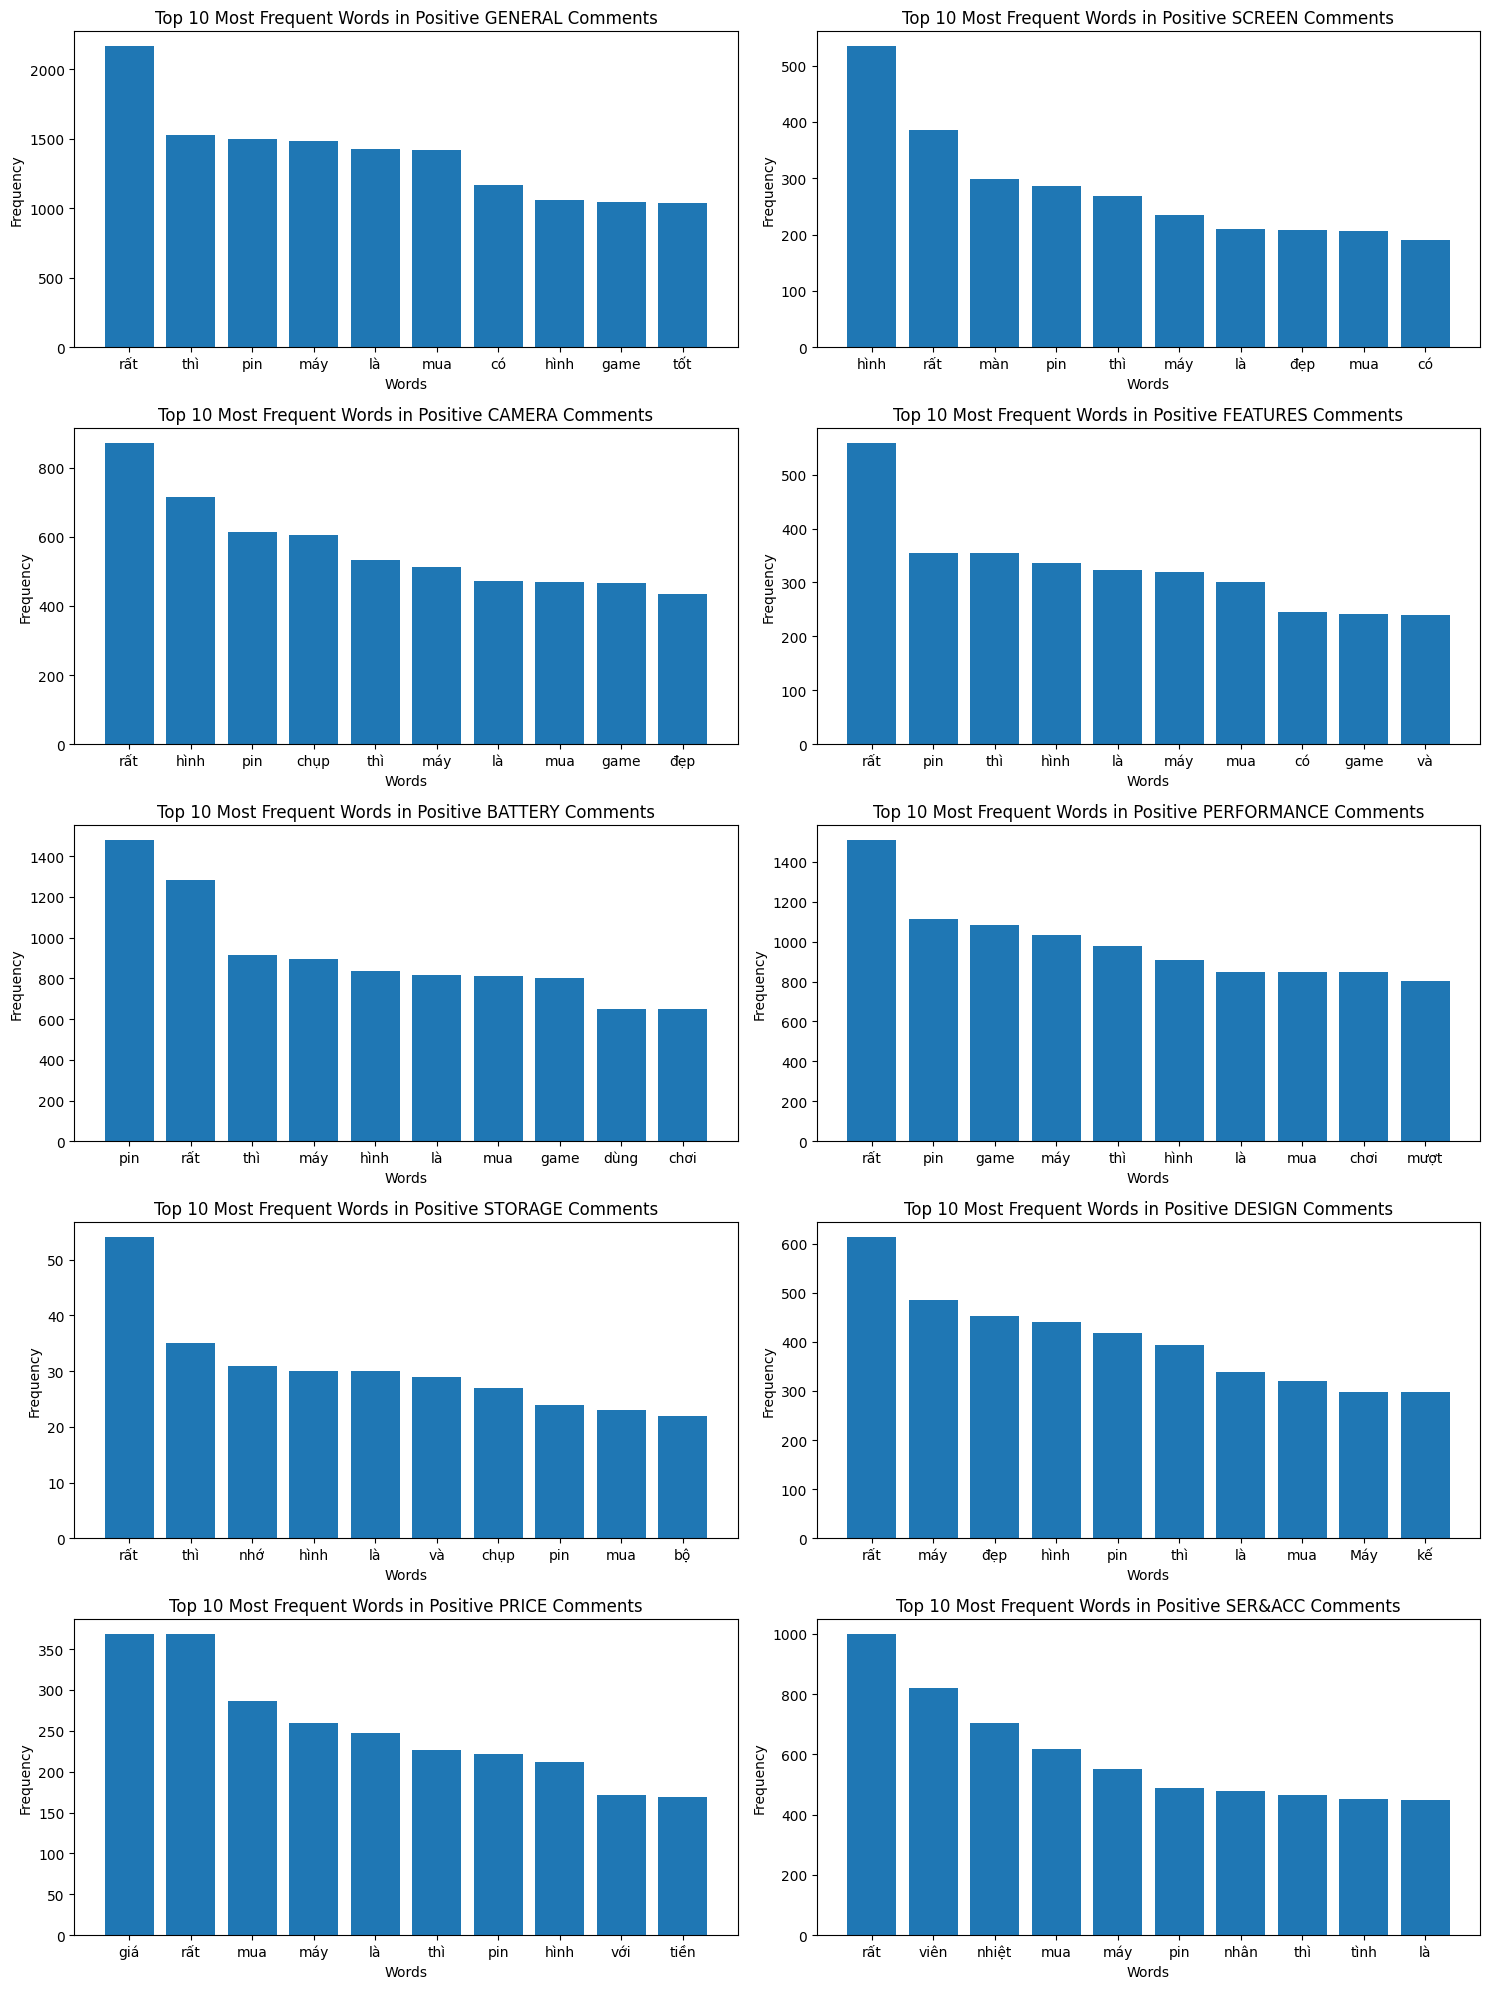

In [33]:
visualize_top_frequent_word("Positive")

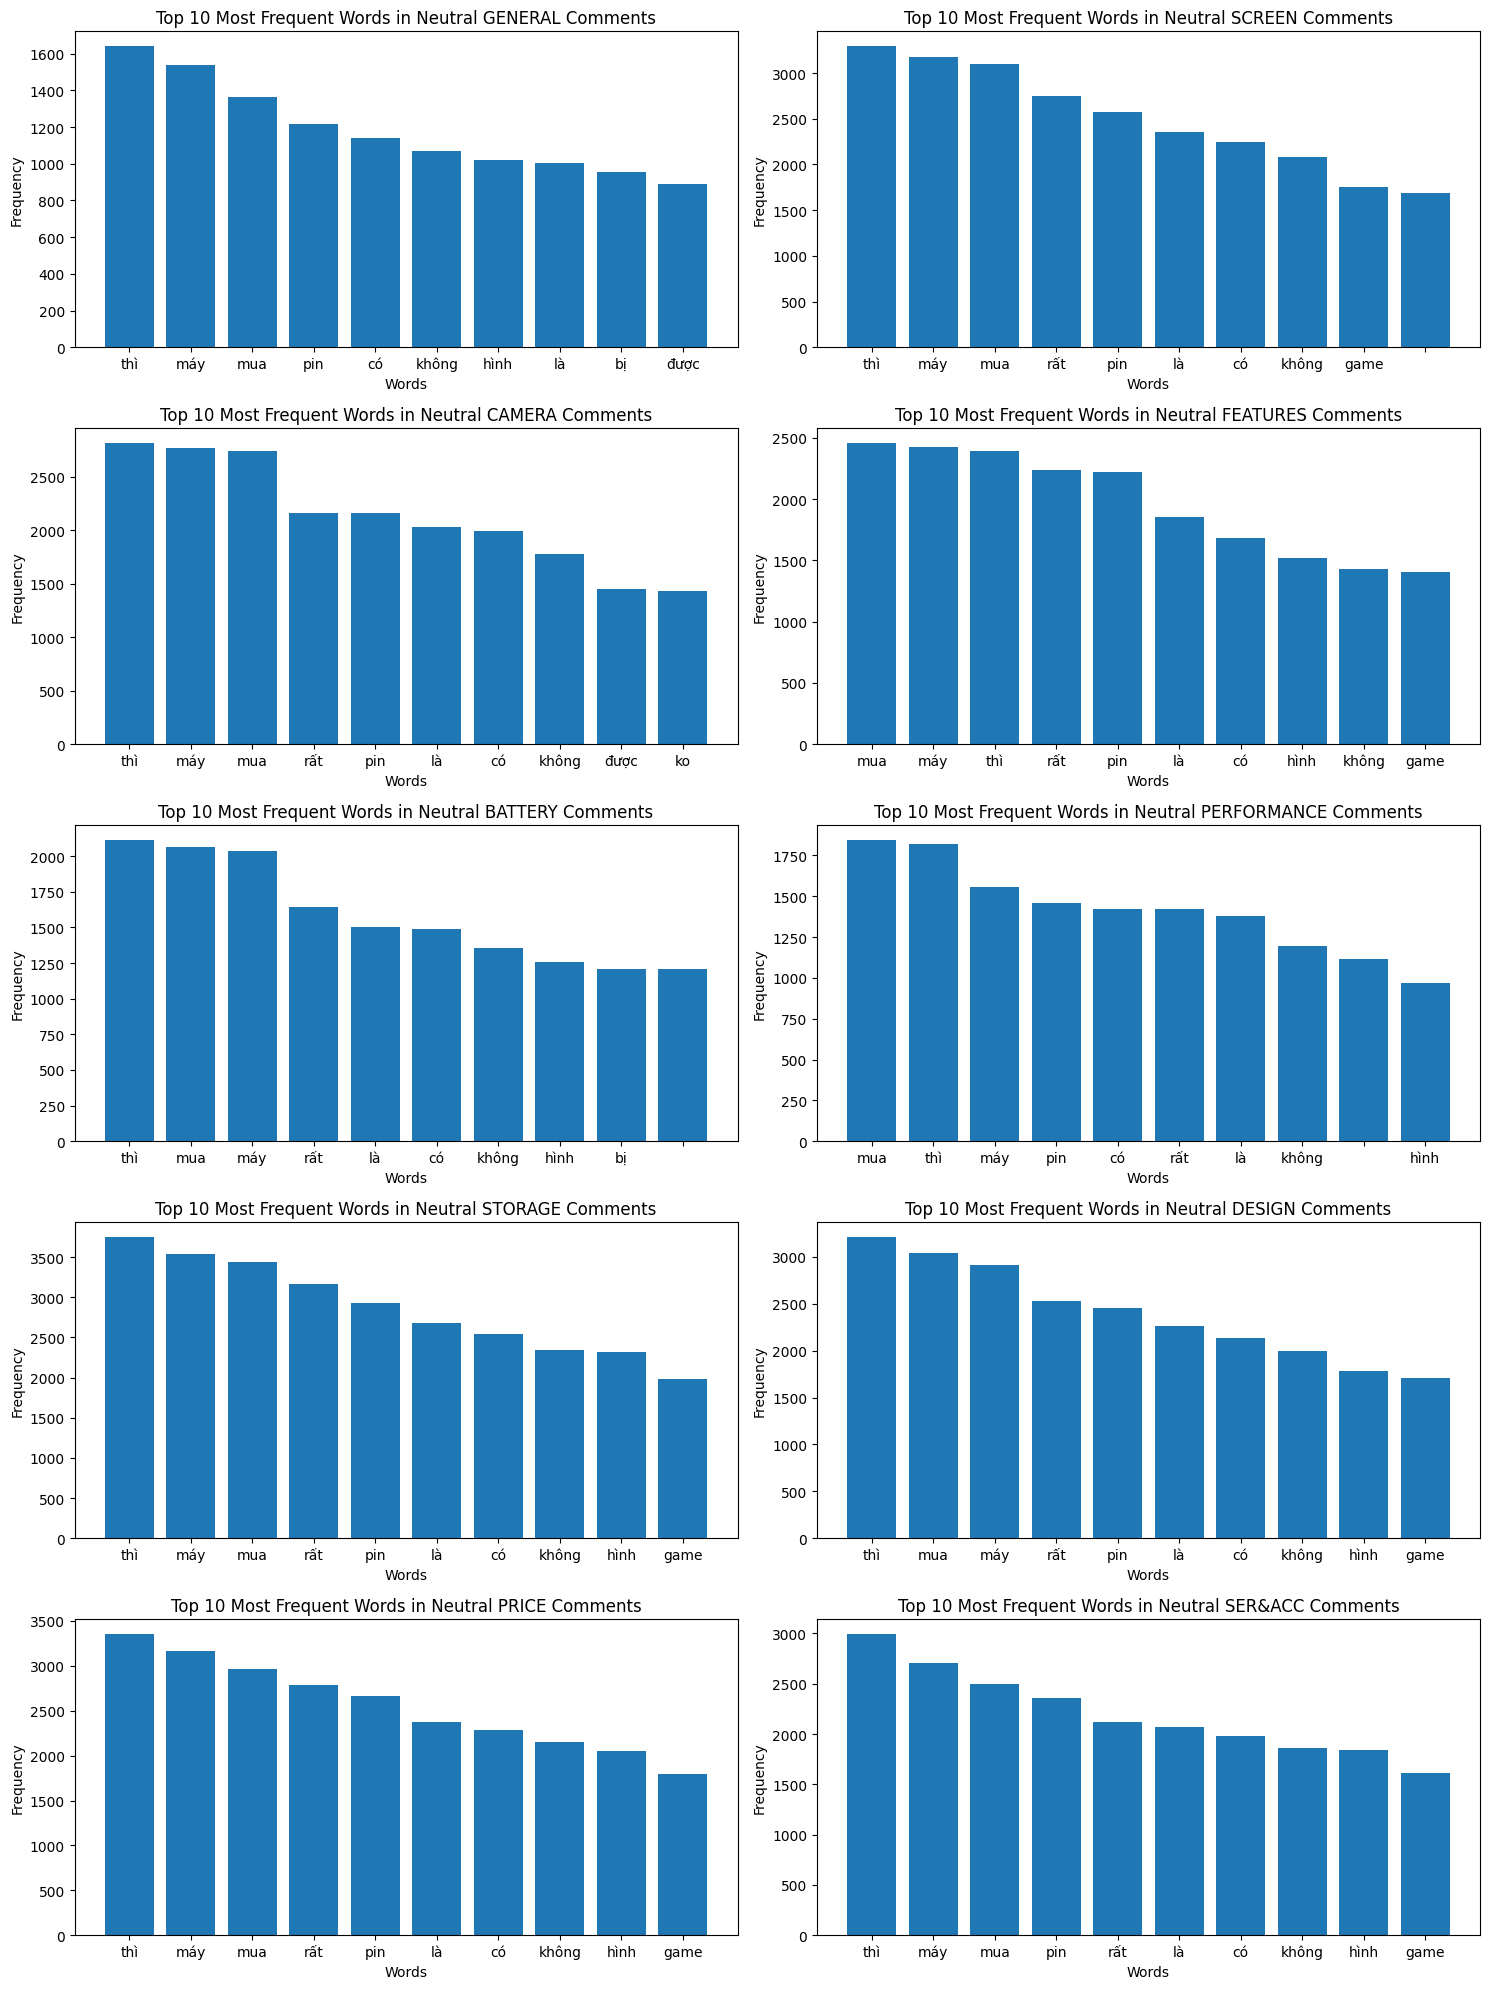

In [34]:
visualize_top_frequent_word("Neutral")

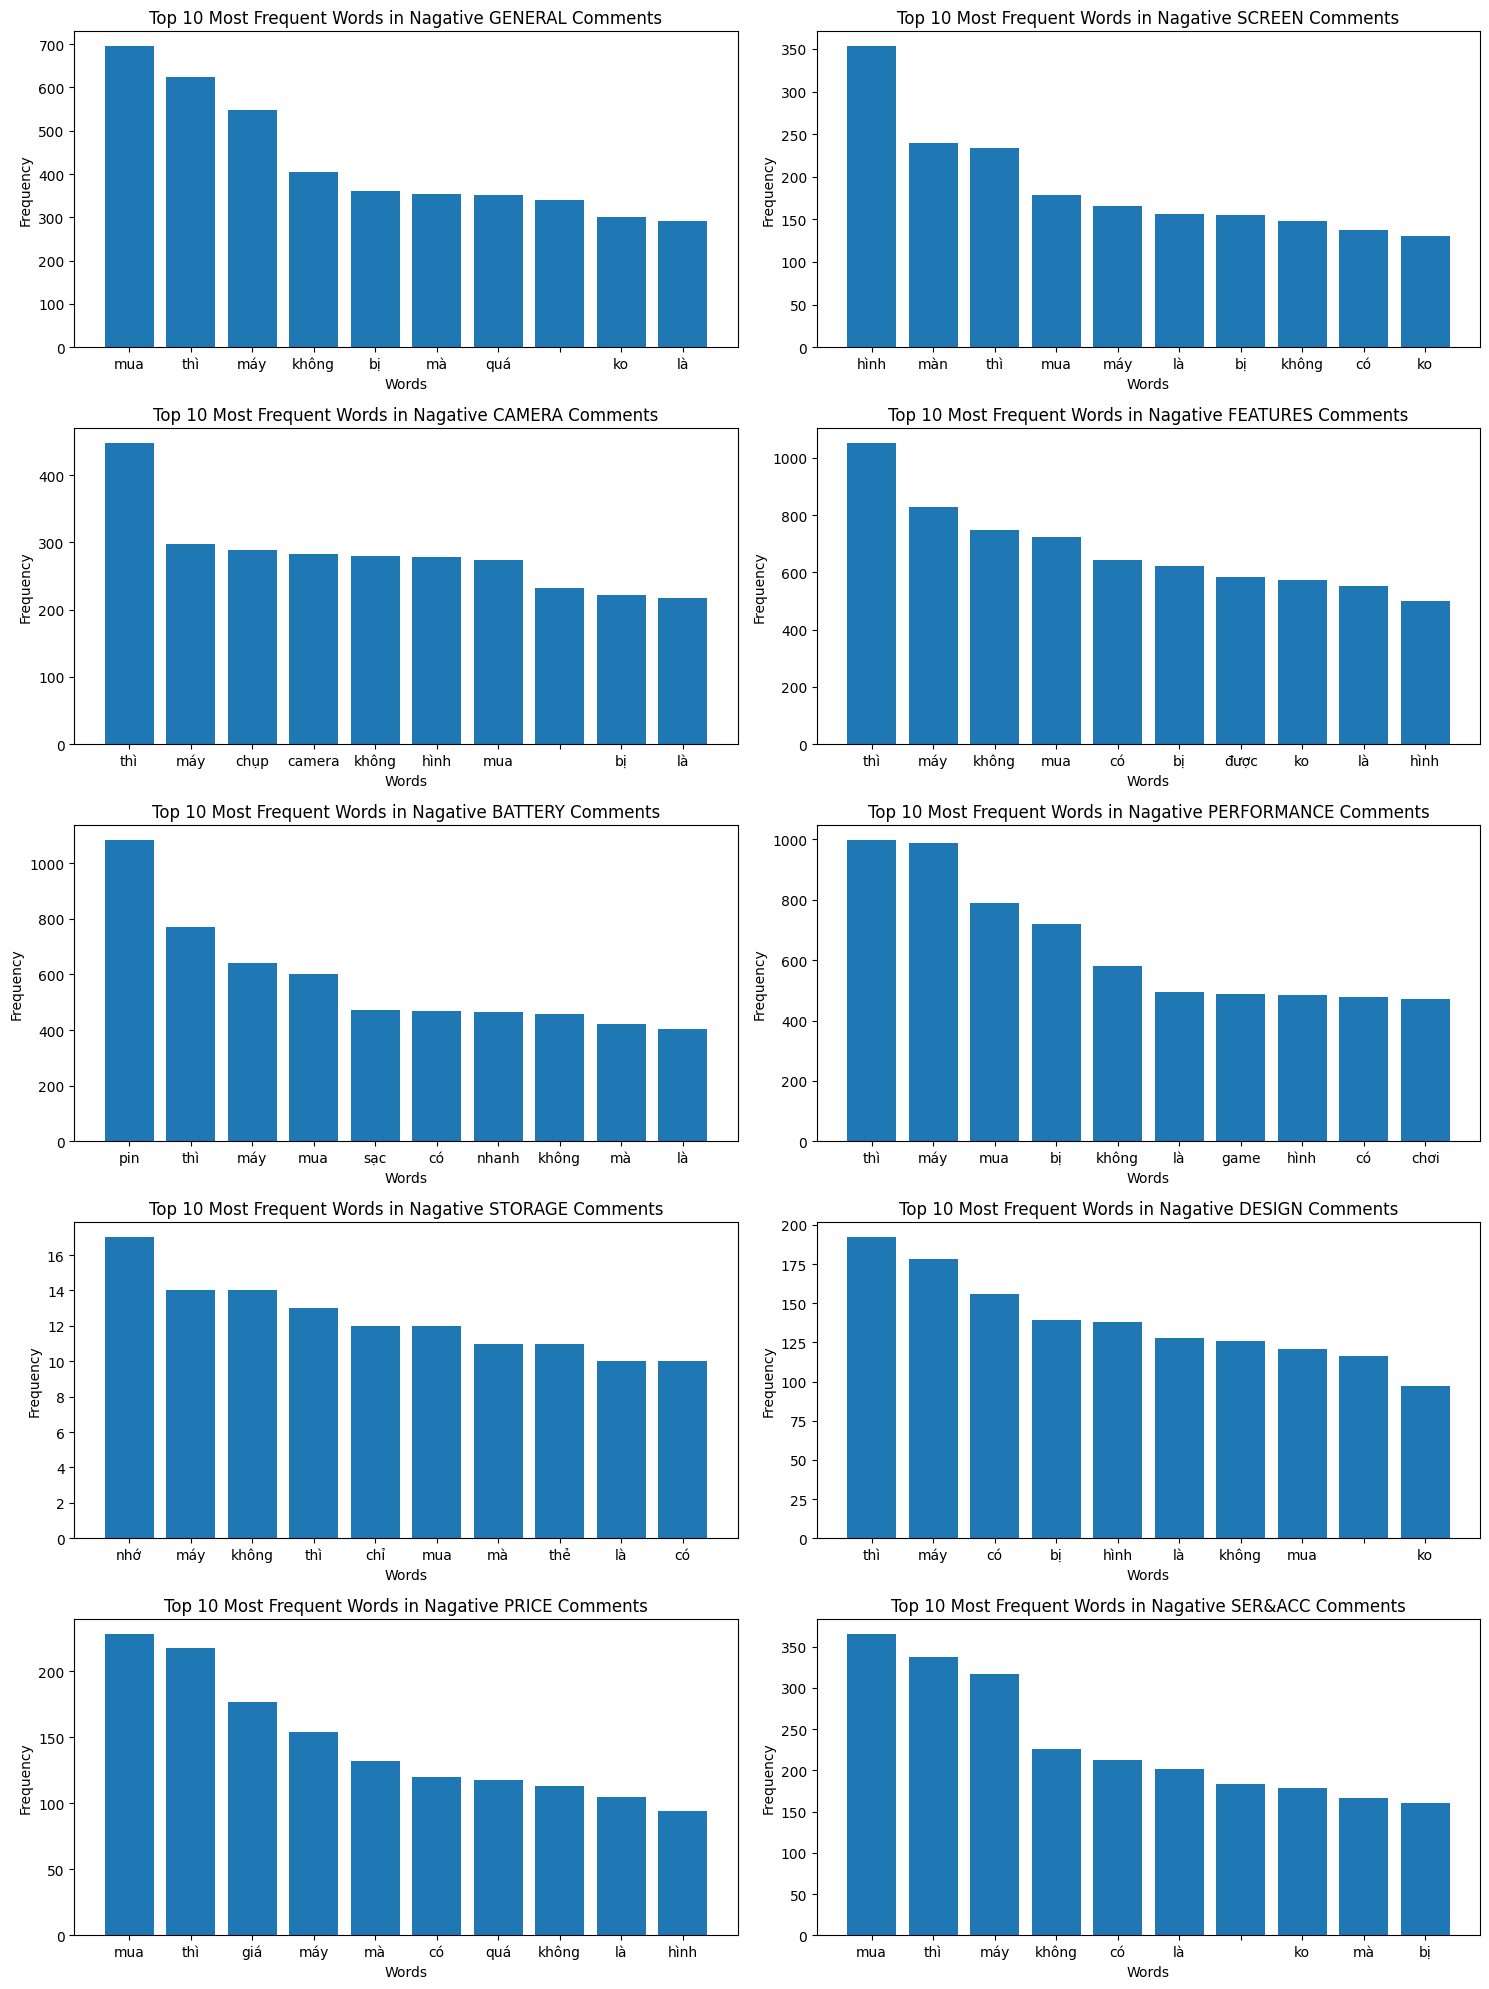

In [35]:
visualize_top_frequent_word("Nagative")

In [26]:
pca_train = PCA(n_components=10)
X_train_pca = pca_train.fit_transform(X_train_tok_enc.A)

Text(0, 0.5, 'Explained Variance Ratio')

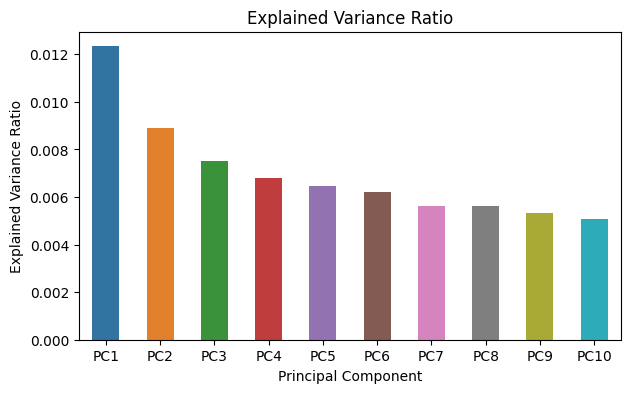

In [27]:
# Plot bar chart for explained variance ratio
plt.figure(figsize=(7, 4))
sns.barplot(x=['PC'+str(i) for i in range(1, 11)], y=pca_train.explained_variance_ratio_, width=0.5)
plt.title('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')

In [28]:
pca_train = PCA(n_components=10)
X_test_pca = pca_train.fit_transform(X_test_tok_enc.A)

In [29]:
# Number of subplots
X = 11

# Calculate the number of rows needed based on two columns per row
num_rows = (X + 1) // 2

# Create a subplot grid with two columns
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 4 * num_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each subplot
for i, (ax, col) in enumerate(zip(axes, aspect_cols+['OTHERS'])):
    # Your Seaborn scatter plot code goes here
    sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=df_train[col], ax=ax)

    # Set title for the subplot
    ax.set_title(f'Subplot of {col}')

# Remove empty subplots if the number of X is odd
if X % 2 == 1:
    fig.delaxes(axes[-1])

# Automatically adjust layout
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.